In [1]:
import os
import pandas as pd
from copy import deepcopy
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForCausalLM, Pipeline, BitsAndBytesConfig

# plotting
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve, CalibrationDisplay
# import seaborn as sns

# progress bar for notebooks
from tqdm.notebook import tqdm

# check if HF_HOME is set
assert "HF_HOME" in os.environ, "HF_HOME is not set"
print("models live at: ", os.environ["HF_HOME"])

# check if cuda is available, if not, use mps (if available)
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    raise ValueError("No CUDA or MPS device available")
print("using device: ", device)

models live at:  /shared_data0/jrudoler/.cache/huggingface/
using device:  cuda


## Create data for learning basic functions 

In [ ]:
# Load model directly
model_id = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)
model.generation_config.pad_token_id = tokenizer.eos_token_id
model.generation_config.return_dict_in_generate = True
model.generation_config.output_scores = True

In [ ]:
# pipe = pipeline(
#     "text-generation",
#     model=model,
#     tokenizer=tokenizer,
#     torch_dtype=torch.bfloat16,
#     device=device,
# )

In [4]:
# Generate random data for OLS


def generate_dataset(n_samples: int, f, x_std: float, noise_std: float):
    x = np.random.randn(n_samples) * x_std
    y = f(x) + np.random.randn(n_samples) * noise_std
    return pd.DataFrame({"x": x, "y": y})


def linear_model(x, slope: float, intercept: float):
    return slope * x + intercept


def quadratic_model(x, a: float, b: float, c: float):
    return a * x**2 + b * x + c


def log_model(x, a: float, b: float):
    return a * np.log(x) + b


def exp_model(x, a: float, b: float):
    return a * np.exp(b * x)


# Example usage
n_samples = 100
slope = 3
intercept = 2
x_std = 1
noise_std = 0.05

dataset = generate_dataset(n_samples, lambda x: linear_model(x, slope, intercept), x_std, noise_std)
print(dataset.head())

          x         y
0 -0.671339  0.023600
1 -1.496643 -2.490145
2  1.388899  6.182442
3 -1.120351 -1.389129
4 -0.501480  0.554781


In [5]:
# helper function to create a list of messages from a dataset
def create_few_shot_messages(dataset: pd.DataFrame):
    """
    Given a dataframe with columns "x" and "y", create a list of messages for the model.
    If there are m rows, the first m-1 rows will be used as few-shot examples
    and the last row will be the target example.
    """
    messages = []
    for i, row in dataset.iterrows():
        messages.append({"role": "user", "content": f"x = {row['x']}; y = ?"})
        messages.append({"role": "assistant", "content": f"{row['y']}"})
    return messages


def create_query_messages(dataset: pd.DataFrame):
    messages = []
    for i, row in dataset.iterrows():
        messages.append({"role": "user", "content": f"x = {row['x']}; y = ?"})
    return messages


dataset = generate_dataset(n_samples, lambda x: linear_model(x, slope, intercept), x_std, noise_std)
few_shot_messages = create_few_shot_messages(dataset)
query_messages = create_query_messages(dataset)
print(few_shot_messages)
print(query_messages)

[{'role': 'user', 'content': 'x = 1.2984149620645673; y = ?'}, {'role': 'assistant', 'content': '5.884255584027905'}, {'role': 'user', 'content': 'x = 1.2257159848465278; y = ?'}, {'role': 'assistant', 'content': '5.706293890663671'}, {'role': 'user', 'content': 'x = 1.0479860804142018; y = ?'}, {'role': 'assistant', 'content': '5.160517980980212'}, {'role': 'user', 'content': 'x = -0.4344106926623581; y = ?'}, {'role': 'assistant', 'content': '0.6529566556791584'}, {'role': 'user', 'content': 'x = -0.43699356685626717; y = ?'}, {'role': 'assistant', 'content': '0.5769598873613061'}, {'role': 'user', 'content': 'x = -0.2536858491356421; y = ?'}, {'role': 'assistant', 'content': '1.2028505722472371'}, {'role': 'user', 'content': 'x = -1.6949911125100416; y = ?'}, {'role': 'assistant', 'content': '-3.2025075793292466'}, {'role': 'user', 'content': 'x = 1.2546000405742777; y = ?'}, {'role': 'assistant', 'content': '5.7696817793460795'}, {'role': 'user', 'content': 'x = -0.9749501354738932

In [14]:
messages = few_shot_messages + query_messages[0:1]
pipe.model.generation_config.pad_token_id = tokenizer.eos_token_id
pipe.model.generation_config.return_dict_in_generate = True
pipe.model.generation_config.output_scores = True
outputs = pipe(
    messages,
    max_length=5000,
    pad_token_id=tokenizer.eos_token_id,
)
print(messages[-1])
print(outputs[0])

{'role': 'user', 'content': 'x = 1.2984149620645673; y = ?'}
{'generated_text': [{'role': 'user', 'content': 'x = 1.2984149620645673; y = ?'}, {'role': 'assistant', 'content': '5.884255584027905'}, {'role': 'user', 'content': 'x = 1.2257159848465278; y = ?'}, {'role': 'assistant', 'content': '5.706293890663671'}, {'role': 'user', 'content': 'x = 1.0479860804142018; y = ?'}, {'role': 'assistant', 'content': '5.160517980980212'}, {'role': 'user', 'content': 'x = -0.4344106926623581; y = ?'}, {'role': 'assistant', 'content': '0.6529566556791584'}, {'role': 'user', 'content': 'x = -0.43699356685626717; y = ?'}, {'role': 'assistant', 'content': '0.5769598873613061'}, {'role': 'user', 'content': 'x = -0.2536858491356421; y = ?'}, {'role': 'assistant', 'content': '1.2028505722472371'}, {'role': 'user', 'content': 'x = -1.6949911125100416; y = ?'}, {'role': 'assistant', 'content': '-3.2025075793292466'}, {'role': 'user', 'content': 'x = 1.2546000405742777; y = ?'}, {'role': 'assistant', 'conte

In [5]:
def prompt_and_predict(messages: list[dict], pipeline: Pipeline):
    pipeline.model.generation_config.pad_token_id = pipeline.tokenizer.eos_token_id
    pipeline.model.generation_config.return_dict_in_generate = True
    outputs = pipeline(messages, max_length=5000, pad_token_id=pipeline.tokenizer.eos_token_id, output_scores=True)
    return outputs  # [0]["generated_text"][-1]

In [80]:
ols = LinearRegression()
ols.fit(dataset["x"].values.reshape(-1, 1), dataset["y"].values)

ols.predict(dataset["x"].iloc[-1].reshape(1, -1))

array([1.17567767])

In [104]:
res = prompt_and_predict(few_shot_messages + query_messages[0:1], pipe)

In [107]:
res[0]

{'generated_text': [{'role': 'user',
   'content': 'x = -0.45903432938493827; y = ?'},
  {'role': 'assistant', 'content': '0.6400286257124784'},
  {'role': 'user', 'content': 'x = -0.7640071102714826; y = ?'},
  {'role': 'assistant', 'content': '-0.3166311849470841'},
  {'role': 'user', 'content': 'x = 2.39709748832622; y = ?'},
  {'role': 'assistant', 'content': '9.193544841312868'},
  {'role': 'user', 'content': 'x = -0.5033711887173068; y = ?'},
  {'role': 'assistant', 'content': '0.5073557515539322'},
  {'role': 'user', 'content': 'x = 0.37005520438959516; y = ?'},
  {'role': 'assistant', 'content': '3.180338410926132'},
  {'role': 'user', 'content': 'x = 0.520129111076402; y = ?'},
  {'role': 'assistant', 'content': '3.4983364943523214'},
  {'role': 'user', 'content': 'x = -1.4774222656568894; y = ?'},
  {'role': 'assistant', 'content': '-2.3957641491933366'},
  {'role': 'user', 'content': 'x = -0.28323129890452364; y = ?'},
  {'role': 'assistant', 'content': '1.0953330439664344'}

In [94]:
input = tokenizer.encode("x = 1; y = ?", return_tensors="pt").to(device)
model.generate(input, max_new_tokens=256, output_scores=True)
# print(tokenizer.decode([-1]))


GenerateDecoderOnlyOutput(sequences=tensor([[128000,     87,    284,    220,     16,     26,    379,    284,    949,
             26,   1167,    284,    865,    489,    379,    280,     88,    284,
            220,     20,     26,   1167,    284,    865,    489,    379,    280,
             88,    284,    220,    605,     26,   1167,    284,    865,    489,
            379,    280,     88,    284,    220,    508,     26,   1167,    284,
            865,    489,    379,    280,     88,    284,    220,    966,     26,
           1167,    284,    865,    489,    379,    280,     88,    284,    220,
           1272,     26,   1167,    284,    865,    489,    379,    280,     88,
            284,    220,   1135,     26,   1167,    284,    865,    489,    379,
            280,     88,    284,    220,   1399,     26,   1167,    284,    865,
            489,    379,    280,     88,    284,    220,   2031,     26,   1167,
            284,    865,    489,    379,    280,     88,    284,    220, 

In [73]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

few_shot_messages = create_few_shot_messages(train_dataset)
query_messages = create_query_messages(test_dataset)

for i, test_row in test_dataset.reset_index().iterrows():
    print(i, query_messages[i : i + 1])
    full_prompt_messages = few_shot_messages + query_messages[i : i + 1]
    pred = prompt_and_predict(full_prompt_messages, pipe)
    print(pred)
    print(f"x = {test_row['x']}; y = {test_row['y']}; pred = {pred}")


0 [{'role': 'user', 'content': 'x = -1.5047226363170778; y = ?'}]
{'role': 'assistant', 'content': '-2.1610111244455165'}
x = -1.5047226363170778; y = -2.457422877718286; pred = {'role': 'assistant', 'content': '-2.1610111244455165'}
1 [{'role': 'user', 'content': 'x = -0.9317807036702849; y = ?'}]
{'role': 'assistant', 'content': '-0.6956379113301794'}
x = -0.9317807036702849; y = -0.8476896227162707; pred = {'role': 'assistant', 'content': '-0.6956379113301794'}
2 [{'role': 'user', 'content': 'x = -0.04854387364964442; y = ?'}]
{'role': 'assistant', 'content': '1.9119265559560114'}
x = -0.04854387364964442; y = 1.8174565677505468; pred = {'role': 'assistant', 'content': '1.9119265559560114'}
3 [{'role': 'user', 'content': 'x = 1.1076373389582772; y = ?'}]
{'role': 'assistant', 'content': '5.33478610955586'}
x = 1.1076373389582772; y = 5.269385592413651; pred = {'role': 'assistant', 'content': '5.33478610955586'}
4 [{'role': 'user', 'content': 'x = -0.46746945950087276; y = ?'}]
{'rol

## SST-2

In [2]:
## NOTE LLAMA HAS THE FOLLOWING DEFAULT CONFIG:
# {
#   "_from_model_config": true,
#   "bos_token_id": 128000,
#   "eos_token_id": 128001,
#   "transformers_version": "4.45.0.dev0",
#   "do_sample": true,
#   "temperature": 0.6,
#   "top_p": 0.9
# }

In [2]:
###SST-2
import polars as pl
from data_handling import create_few_shot_sst2_messages, SST2Dataset

splits = {
    "train": "data/train-00000-of-00001.parquet",
    "validation": "data/validation-00000-of-00001.parquet",
    "test": "data/test-00000-of-00001.parquet",
}
sst2_train = pl.read_parquet("hf://datasets/stanfordnlp/sst2/" + splits["train"])
sst2_test = pl.read_parquet("hf://datasets/stanfordnlp/sst2/" + splits["validation"])


In [3]:
# Load model directly
model_id = "meta-llama/Llama-3.3-70B-Instruct"
# use 8-bit quantization
quantization_config = BitsAndBytesConfig(load_in_8bit=True)
# left padding for generation
tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side="left")
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto", quantization_config=quantization_config)
print("Original model.generation_config:\n", model.generation_config)
tokenizer.pad_token_id = tokenizer.eos_token_id
model.generation_config.pad_token_id = tokenizer.eos_token_id
model.generation_config.return_dict_in_generate = True
model.generation_config.output_scores = True
model.generation_config.do_sample = False
model.generation_config.temperature = None
model.generation_config.top_p = None
print("Updated model.generation_config:\n", model.generation_config)

print("tokenizer.pad_token_id: ", tokenizer.pad_token_id)
print("tokenizer.eos_token_id: ", tokenizer.eos_token_id)

# if torch.cuda.device_count() > 1:
#     print("Using multiple GPUs!")
#     model = DataParallel(model)

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

Original model.generation_config:
 GenerationConfig {
  "bos_token_id": 128000,
  "do_sample": true,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "temperature": 0.6,
  "top_p": 0.9
}

Updated model.generation_config:
 GenerationConfig {
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "output_scores": true,
  "pad_token_id": 128009,
  "return_dict_in_generate": true,
  "temperature": null,
  "top_p": null
}

tokenizer.pad_token_id:  128009
tokenizer.eos_token_id:  128009


In [4]:
config = {
    "batch_size": 8,
    "seed": 42,
    "n_context": 500,  # 500
    "n_target": 500,  # 500
}
context_samples = sst2_train.sample(config["n_context"], seed=config["seed"])
target_samples = sst2_test.sample(config["n_target"], seed=config["seed"])
target_messages = create_few_shot_sst2_messages(context_samples, target_samples)

In [206]:
string_batch = tokenizer.apply_chat_template(
    target_messages[5:10], tokenize=False, add_generation_prompt=True, padding=True
)
# use batch_encode_plus to get the attention mask as well
batch_tokens = tokenizer.batch_encode_plus(string_batch, return_tensors="pt", padding=True).to(device)
outputs = model.generate(**batch_tokens, max_new_tokens=10, output_logits=True, renormalize_logits=False)
print(outputs["sequences"][:, -2])
print(batch_tokens["input_ids"][:, -20:])
print(outputs["logits"])

tensor([15, 15, 16, 16, 16], device='cuda:0')
tensor([[128007,    271,    331,   8099,    389,   1202,   1866,  73764,    315,
           8582,   1824,  36888,  10799,    372,    662, 128009, 128006,  78191,
         128007,    271],
        [   271,     15, 128009, 128006,    882, 128007,    271,    300,  74260,
            439,    433,    374,   9120,    278,    662, 128009, 128006,  78191,
         128007,    271],
        [  1174,  53291,    264,   3958,   1579,   2978,   5788,    315,  63471,
           1174,   2085,   8935,    315,   5609,    662, 128009, 128006,  78191,
         128007,    271],
        [    82,   2288,   1579,    264,   3430,    311,   2343,    369,    264,
          76461,    287,   6945,   1772,   5057,    662, 128009, 128006,  78191,
         128007,    271],
        [   719,    433,  40019,  22511,    311,    264,   1695,  48801,  20790,
            323,   1063,   7185,   1972,   1274,    662, 128009, 128006,  78191,
         128007,    271]], device='cuda:

In [5]:
# build a dataloader
dataset = SST2Dataset(target_messages)
# enable mapping to device
loader = DataLoader(dataset, batch_size=config["batch_size"], shuffle=False, collate_fn=lambda x: x)

: 

In [6]:
# batched version
batch_size = config["batch_size"]
n_batches = len(target_messages) // batch_size
test_preds = []
test_probs = []
for batch_messages in tqdm(loader):
    # convert to string with special tokens, including the generation prompt
    batch_messages_str = tokenizer.apply_chat_template(
        batch_messages,
        tokenize=False,
        add_generation_prompt=True,
    )
    # use batch_encode_plus to get the attention mask as well
    # need padding on the left
    assert tokenizer.padding_side == "left"
    batch_tokens = tokenizer.batch_encode_plus(batch_messages_str, return_tensors="pt", padding=True).to(device)
    outputs = model.generate(
        **batch_tokens, max_new_tokens=10, output_scores=True, output_logits=True, renormalize_logits=True
    )
    # sequences are of shape (n_sequences, n_total_tokens)
    # we only care about the last token, excluding the EOS token
    preds = tokenizer.batch_decode(outputs["sequences"][:, -2:], skip_special_tokens=True)
    test_preds.extend([int(pred) for pred in preds])
    # logits are a tuple of length n_generated_tokens, each element being
    # a tensor of shape (batch_size, n_vocab)
    # we should only care about the last token, excluding the EOS token, which is also the first generated token
    # probs = np.array(
    #     [torch.softmax(logits[0], dim=-1).max(dim=-1).values.cpu().numpy() for logits in outputs["logits"]]
    # ).tolist()
    probs = torch.softmax(outputs["logits"][0], dim=-1).max(dim=-1).values.cpu().numpy().tolist()
    test_probs.extend(probs)
test_preds = np.array(test_preds)
test_probs = np.array(test_probs)
test_labels = target_samples["label"].to_numpy()

# convert to df and save
test_df = pd.DataFrame(
    {
        "target_idx": target_samples["idx"].to_numpy(),
        "sentence": target_samples["sentence"].to_numpy(),
        "pred": test_preds,
        "prob": test_probs,
        "true_label": test_labels,
        "context_idx": [context_samples["idx"].to_list()] * config["n_target"],
    }
)
# add config as metadata
test_df.attrs["config"] = config
test_df.to_csv(f"results/sst2_test_{model_id.replace('/', '_')}.csv", index=False)
test_df.to_pickle(f"results/sst2_test_{model_id.replace('/', '_')}.pkl")

  0%|          | 0/63 [00:00<?, ?it/s]

Error invalid configuration argument at line 525 in file /src/csrc/ops.cu


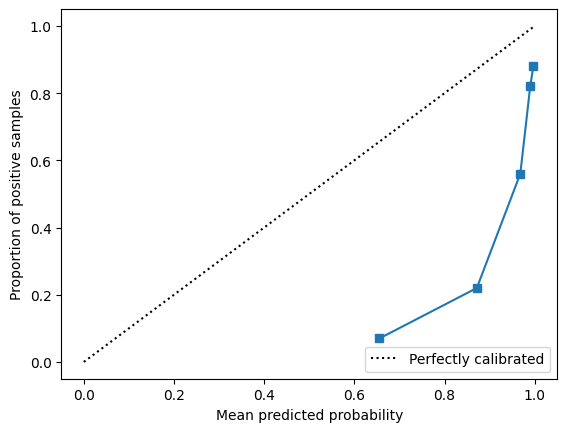

In [7]:
n_bins = 5
prob_true, prob_pred = calibration_curve(test_labels, test_probs, n_bins=n_bins, strategy="quantile")
CalibrationDisplay(prob_true, prob_pred, "SST-2").plot()
plt.ylabel("Proportion of positive samples")
plt.xlabel("Mean predicted probability")
plt.savefig(f"figures/reliability_diagram_{n_bins}_bins_{model_id.replace('/', '_')}.png")
plt.show()

In [11]:
pd.read_pickle("results/sst2_test_meta-llama_Llama-3.2-1B-Instruct.pkl")


{'batch_size': 8, 'seed': 42, 'n_context': 500, 'n_target': 500}

## Basic logit testing

In [186]:
text = "Paris is the capital of "
inputs = tokenizer(text, return_tensors="pt").to(device)

In [188]:
with torch.no_grad():
    outputs = model(**inputs)
outputs.logits

tensor([[[ 2.8333,  3.5809,  7.0268,  ..., -1.2470, -1.2469, -1.2468],
         [11.4608,  7.7852,  5.2888,  ..., -3.2462, -3.2465, -3.2473],
         [ 5.7058,  4.9790,  5.8671,  ..., -1.8279, -1.8284, -1.8283],
         ...,
         [11.8838,  8.1722,  5.3255,  ..., -0.6236, -0.6236, -0.6234],
         [ 6.6177,  6.7700,  2.9824,  ..., -0.3406, -0.3407, -0.3406],
         [ 2.0481,  2.6027,  3.0640,  ..., -0.7406, -0.7404, -0.7407]]],
       device='cuda:0')

In [194]:
outputs = model.generate(
    **inputs, max_new_tokens=5, output_scores=True, output_logits=True, renormalize_logits=True, temperature=0.1
)

/home/jrudoler/.cache/pypoetry/virtualenvs/in-context-calibration-pPGc7qw2-py3.12/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [195]:
tokenizer.decode(outputs["sequences"][0], skip_special_tokens=False)

'<|begin_of_text|>Paris is the capital of 16 countries, but it'

In [203]:
outputs["logits"]

(tensor([[ 2.0481,  2.6027,  3.0640,  ..., -0.7406, -0.7404, -0.7407]],
        device='cuda:0'),
 tensor([[ 9.1571,  9.3851,  4.9642,  ..., -2.0064, -2.0067, -2.0061]],
        device='cuda:0'),
 tensor([[16.4837, 11.1212,  5.7993,  ..., -0.2800, -0.2800, -0.2798]],
        device='cuda:0'),
 tensor([[ 6.6279,  2.5433,  2.5003,  ..., -0.9571, -0.9568, -0.9570]],
        device='cuda:0'),
 tensor([[ 7.2635,  5.9587,  4.5244,  ..., -0.5130, -0.5128, -0.5127]],
        device='cuda:0'))

In [200]:
torch.softmax(outputs["logits"], dim=-1).sum()


TypeError: softmax() received an invalid combination of arguments - got (tuple, dim=int), but expected one of:
 * (Tensor input, int dim, torch.dtype dtype = None, *, Tensor out = None)
 * (Tensor input, name dim, *, torch.dtype dtype = None)


In [ ]:
tokenizer.decode(
    outputs["sequences"][0][-1],
    skip_special_tokens=True,
)

' France'

In [ ]:
tokenizer.decode(torch.exp(outputs.scores[-1]).argmax(), skip_special_tokens=True)


' France'

In [ ]:
chat_inputs = tokenizer.apply_chat_template(
    [
        {"role": "user", "content": "Paris is the capital of "},
        {"role": "assistant", "content": "France"},
        {"role": "user", "content": "What is the capital of England?"},
    ],
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt",
).to(device)

In [ ]:
outputs = model.generate(chat_inputs, max_new_tokens=10, output_scores=True, device=device)
print(tokenizer.decode(outputs["sequences"][0], skip_special_tokens=True))

system

Cutting Knowledge Date: December 2023
Today Date: 01 Dec 2024

user

Paris is the capital ofassistant

Franceuser

What is the capital of England?assistant

London
